In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor, plot_importance
import seaborn as sns
from sklearn.model_selection import KFold, train_test_split
from tqdm.notebook import tqdm
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_squared_error
import optuna
import tqdm
%matplotlib inline

warnings.filterwarnings('ignore')

In [2]:
def load_data(base_path):
    _test = pd.read_csv(base_path + 'test.csv',index_col='id')
    _train = pd.read_csv(base_path + 'train.csv',index_col='id')
    _label = _train['target']
    del _train['target']
    _data = pd.concat([_train,_test]).sort_index()
    return _data, _label, _train.index, _test.index 
base_path = 'E:/python/data/训练赛/TabularPlaygroundSeries/tabular-playground-series-feb-2021/'
data, label, train_index, test_index = load_data(base_path)

In [3]:
categorys = [f for f in data.columns.tolist() if f.startswith('cat')]
continues = [f for f in data.columns.tolist() if f.startswith('cont')]
features = categorys + continues
# for cate in categorys:
#     lr = LabelEncoder()
#     data[cate] = lr.fit_transform(data[cate])
# data[categorys]


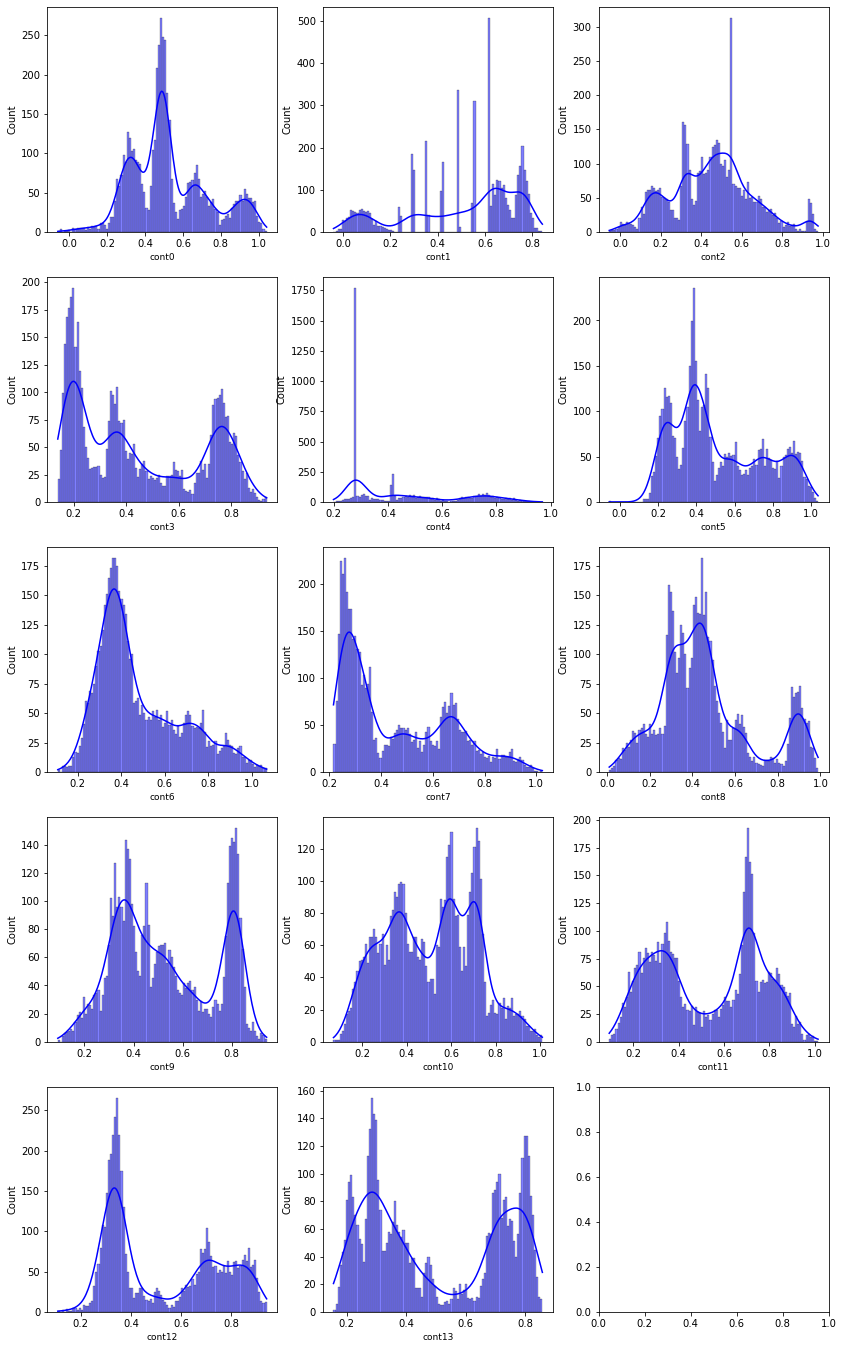

In [4]:
fig, ax = plt.subplots(5,3,figsize=(14,24))
for i, feature in enumerate(continues):
    plt.subplot(5,3,i+1)
    sns.histplot(data[feature][::100],color='blue',kde=True,bins=100)
    plt.xlabel(feature, fontsize=9)
plt.show()

In [5]:
inits = [[0.3, 0.5, 0.7, 0.9], 
         [0.039, 0.093, 0.24, 0.29, 0.35, 0.42, 0.49, 0.56, 0.62, 0.66, 0.76],
         [0.176, 0.322, 0.416, 0.495, 0.548, 0.618, 0.707, 0.937],
         [0.2, 0.35, 0.44, 0.59, 0.75, 0.83],
         [0.28, 0.31, 0.42, 0.5, 0.74, 0.85],
         [0.25, 0.38, 0.43, 0.58, 0.75, 0.9],
         [0.34, 0.48, 0.7, 0.88],
         [0.25, 0.29, 0.35, 0.48, 0.61, 0.68, 0.78, 0.9],
         [0.11, 0.2, 0.3, 0.35, 0.45, 0.6, 0.76, 0.9],
         [0.22, 0.32, 0.38, 0.44, 0.53, 0.63, 0.71, 0.81, 0.87],
         [0.19, 0.27, 0.37, 0.46, 0.56, 0.61, 0.71, 0.86],
         [0.23, 0.35, 0.52, 0.7, 0.84],
         [0.27, 0.32, 0.35, 0.49, 0.63, 0.7, 0.79, 0.88],
         [0.22, 0.29, 0.35, 0.4, 0.47, 0.58, 0.68, 0.72, 0.8]]
gmms = []
for feature, init in zip(continues, inits):
    X_ = np.array(data[feature].tolist()).reshape(-1,1)
    means_init = np.array(init)[:,None]
    gmm_ = GaussianMixture(n_components=len(init),means_init=means_init,random_state=0).fit(X_)
    gmms.append(gmm_)
    preds = gmm_.predict(X_)
    data[f'{feature}_gmm'] =preds
    

In [6]:
X = data.loc[train_index]
X['target'] = label


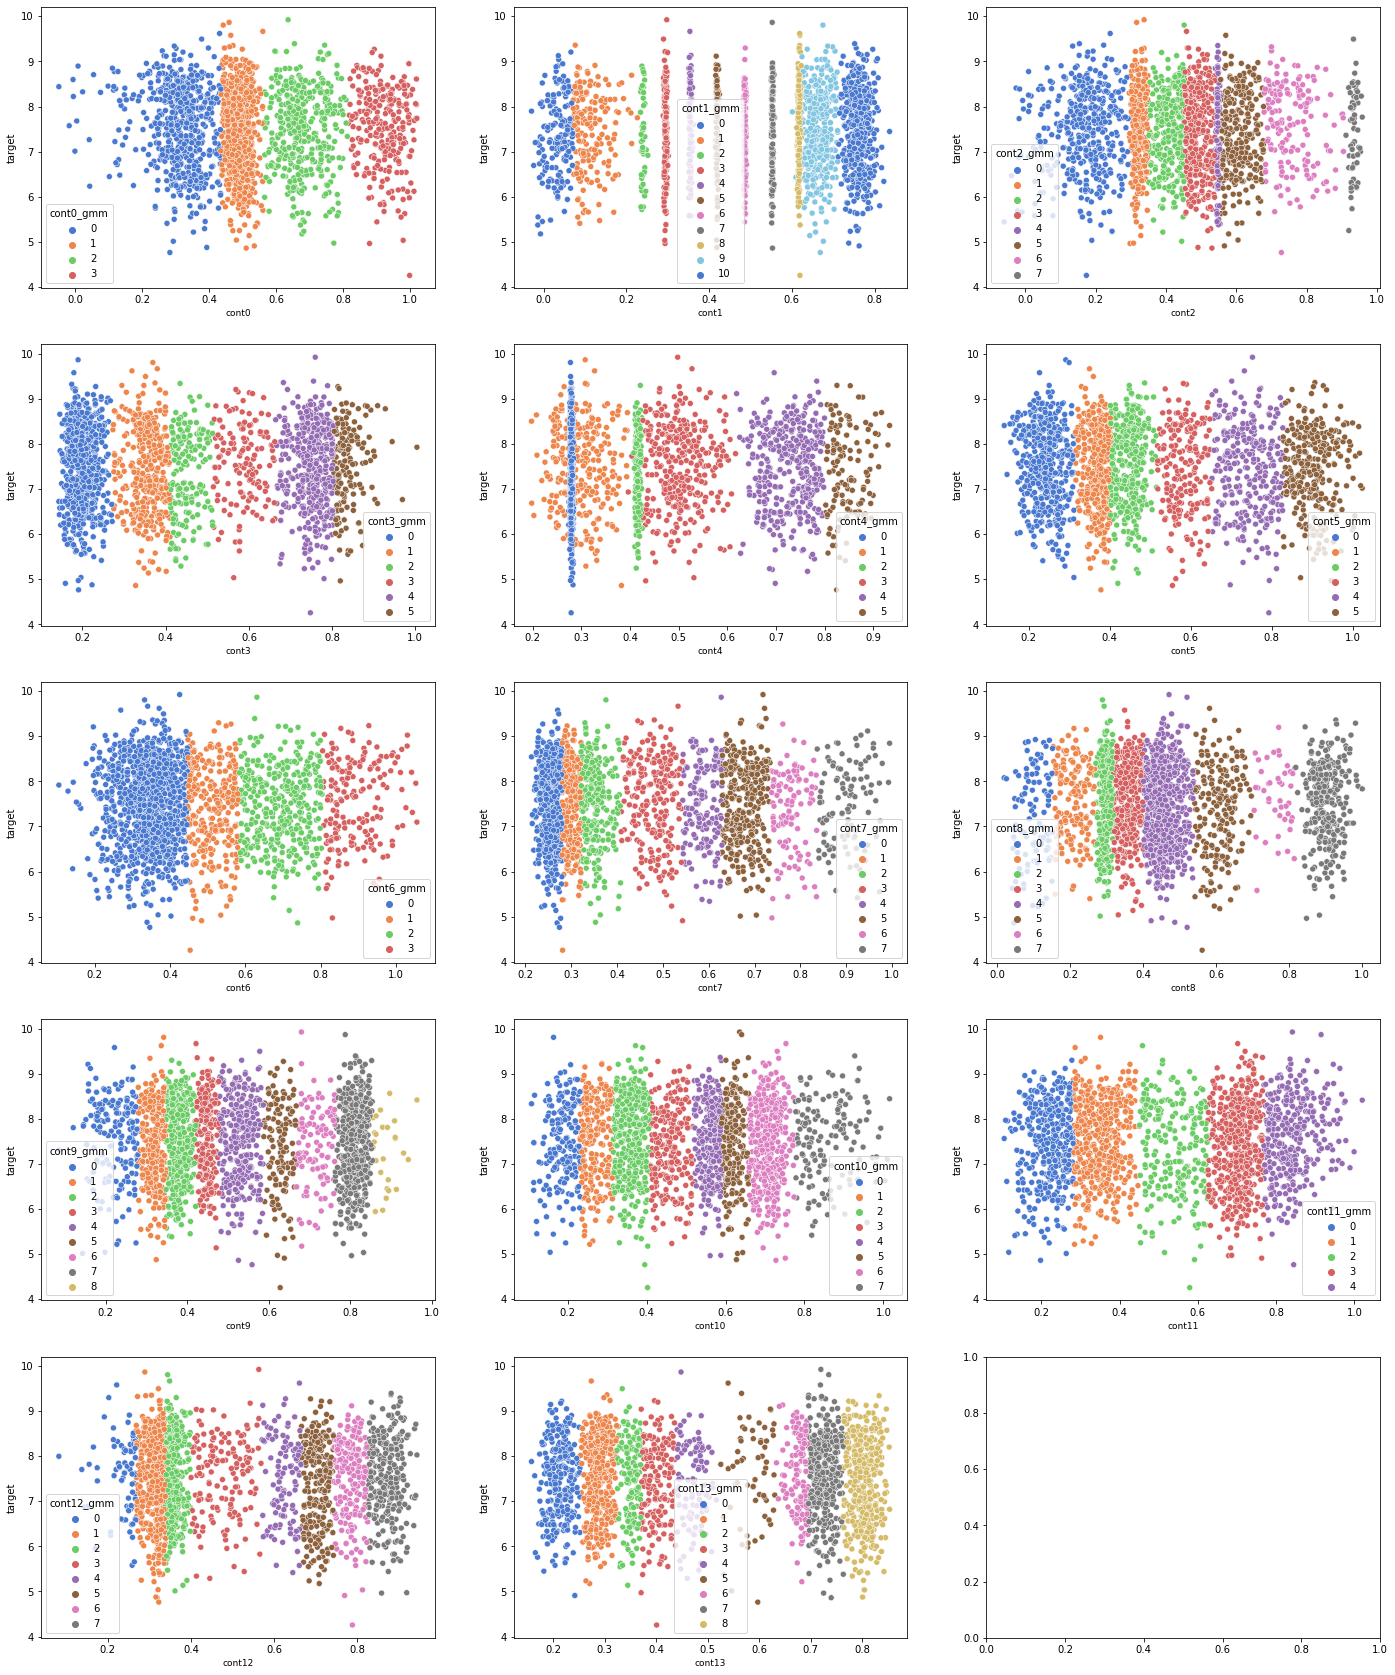

In [7]:
fig, ax = plt.subplots(5,3,figsize=(24,30))
for i, feature in enumerate(continues):
    plt.subplot(5,3,i+1)
    sns.scatterplot(x=feature, y='target', data=X[::150],hue=f'{feature}_gmm',palette='muted')
    plt.xlabel(feature,fontsize=9)
plt.show()

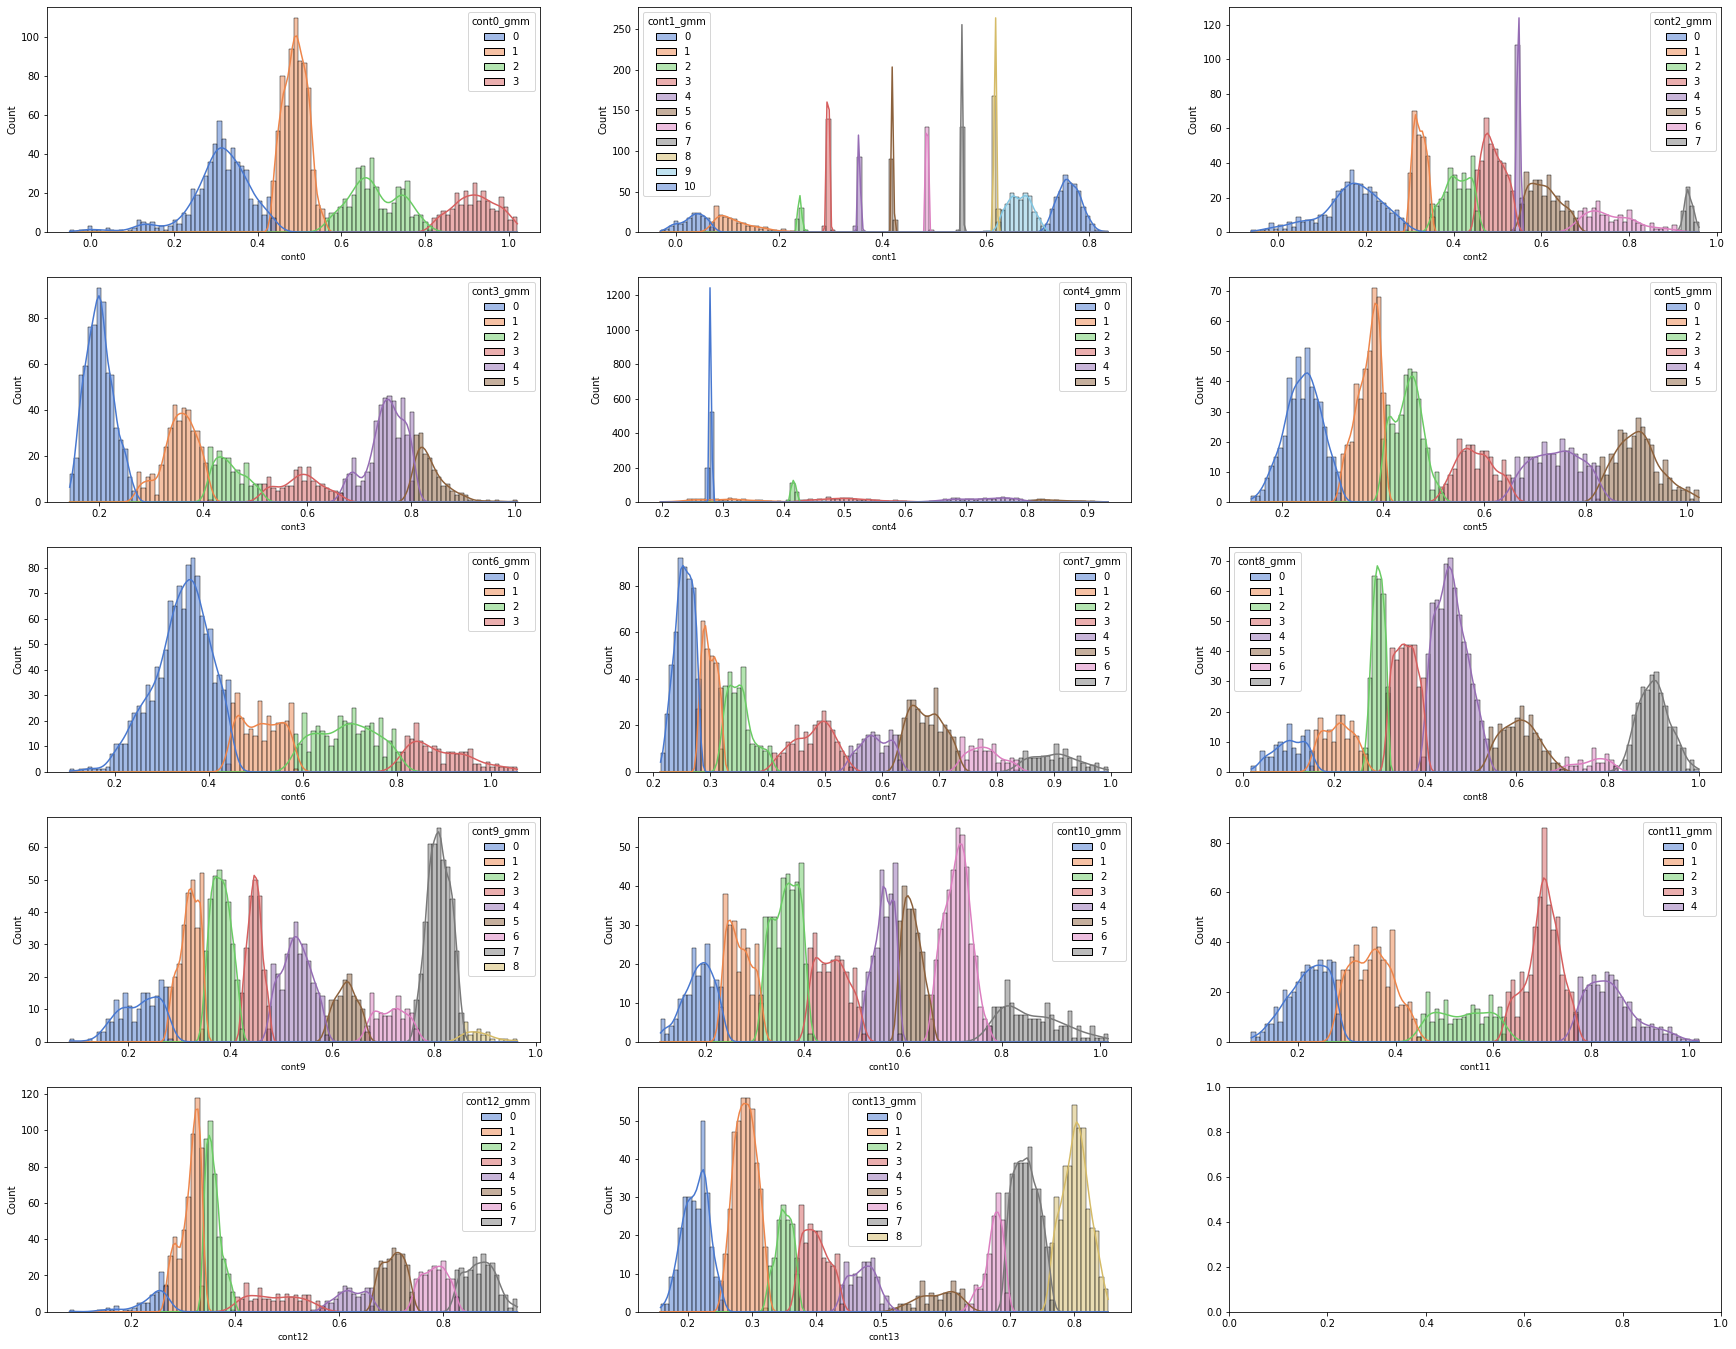

In [8]:
fig, ax = plt.subplots(5,3,figsize=(30,24))
for i, feature in enumerate(continues):
    plt.subplot(5,3,i+1)
    sns.histplot(x=feature,data=X[::150],kde=True,bins=100,hue=f'{feature}_gmm',palette='muted')
    plt.xlabel(feature,fontsize=9)
plt.show()

In [20]:
for feature in continues:
    mu = data.groupby(f'{feature}_gmm')[feature].transform('mean')
    sigma = data.groupby(f'{feature}_gmm')[feature].transform('std')
    data[f'{feature}_gmm_dev'] = (data[feature] - mu) / sigma
for feature in categorys:
    le = LabelEncoder()
    data[feature] = le.fit_transform(data[feature])
X = data.loc[train_index]
X['target'] = label

In [23]:
feature = [f for f in X.columns.to_list() if f not in ['id','target']]

In [28]:
def objective(trial, data=X[features], target=label):

    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.2, random_state=41)
    param = {
        'metric': 'rmse', 
        'random_state': 41,
        'n_estimators': 20000,
        'learning_rate': 0.01,
#         'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 100.),
#         'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
#         'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.01, 1.0),
#         'subsample': trial.suggest_categorical('subsample', [0.2,0.3,0.4,0.5,0.6,0.7,0.8,1.0]),
#         'subsample_freq': trial.suggest_int('subsample_freq', 1, 20),
        'max_depth': trial.suggest_categorical('max_depth', [-1,30,100,300])
#         'num_leaves' : trial.suggest_int('num_leaves', 2, 500),
#         'min_child_samples': trial.suggest_int('min_child_samples', 1, 200),
#         'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10),
#         'cat_smooth' : trial.suggest_int('cat_smooth', 1, 100)
    }

    model = LGBMRegressor(**param)  
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=500)

    preds = model.predict(test_x)    
    rmse = mean_squared_error(test_y, preds,squared=False)

    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Best trial:', study.best_params)

[I 2021-03-15 09:27:44,975] A new study created in memory with name: no-name-c3c380f6-0d99-45f4-be17-48a3800b63e7


[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


[I 2021-03-15 09:28:28,983] Trial 0 finished with value: 0.8459243444896777 and parameters: {'max_depth': 30}. Best is trial 0 with value: 0.8459243444896777.
[I 2021-03-15 09:29:17,171] Trial 1 finished with value: 0.8459243444896777 and parameters: {'max_depth': -1}. Best is trial 0 with value: 0.8459243444896777.


[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


[I 2021-03-15 09:30:05,046] Trial 2 finished with value: 0.8459243444896777 and parameters: {'max_depth': 300}. Best is trial 0 with value: 0.8459243444896777.
[I 2021-03-15 09:30:53,458] Trial 3 finished with value: 0.8459243444896777 and parameters: {'max_depth': -1}. Best is trial 0 with value: 0.8459243444896777.


[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


[I 2021-03-15 09:31:40,553] Trial 4 finished with value: 0.8459243444896777 and parameters: {'max_depth': 100}. Best is trial 0 with value: 0.8459243444896777.


[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


[I 2021-03-15 09:32:27,823] Trial 5 finished with value: 0.8459243444896777 and parameters: {'max_depth': 30}. Best is trial 0 with value: 0.8459243444896777.


[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


[I 2021-03-15 09:33:14,938] Trial 6 finished with value: 0.8459243444896777 and parameters: {'max_depth': 30}. Best is trial 0 with value: 0.8459243444896777.


[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


[I 2021-03-15 09:34:11,785] Trial 7 finished with value: 0.8459243444896777 and parameters: {'max_depth': 300}. Best is trial 0 with value: 0.8459243444896777.


[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


[I 2021-03-15 09:35:02,966] Trial 8 finished with value: 0.8459243444896777 and parameters: {'max_depth': 100}. Best is trial 0 with value: 0.8459243444896777.


[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


[I 2021-03-15 09:35:54,635] Trial 9 finished with value: 0.8459243444896777 and parameters: {'max_depth': 30}. Best is trial 0 with value: 0.8459243444896777.


[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


[I 2021-03-15 09:36:44,340] Trial 10 finished with value: 0.8459243444896777 and parameters: {'max_depth': 30}. Best is trial 0 with value: 0.8459243444896777.
[I 2021-03-15 09:37:32,739] Trial 11 finished with value: 0.8459243444896777 and parameters: {'max_depth': -1}. Best is trial 0 with value: 0.8459243444896777.
[I 2021-03-15 09:38:20,788] Trial 12 finished with value: 0.8459243444896777 and parameters: {'max_depth': -1}. Best is trial 0 with value: 0.8459243444896777.
[I 2021-03-15 09:39:16,459] Trial 13 finished with value: 0.8459243444896777 and parameters: {'max_depth': -1}. Best is trial 0 with value: 0.8459243444896777.


[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


[I 2021-03-15 09:40:08,064] Trial 14 finished with value: 0.8459243444896777 and parameters: {'max_depth': 30}. Best is trial 0 with value: 0.8459243444896777.
[I 2021-03-15 09:41:00,094] Trial 15 finished with value: 0.8459243444896777 and parameters: {'max_depth': -1}. Best is trial 0 with value: 0.8459243444896777.


KeyboardInterrupt: 

In [ ]:
study.trials_dataframe()
optuna.visualization.plot_param_importances(study)
optuna.visualization.plot_parallel_coordinate(study)
optuna.visualization.plot_contour(study, params=['num_leaves', 'max_depth', 'subsample', 'min_child_samples', 'colsample_bytree'])
optuna.visualization.plot_optimization_history(study)

NUM_FOLDS = 10
seed_list = [0,1,2]

test_pred = np.zeros(len(test))
val_pred = np.zeros(len(train))

for seed in tqdm(seed_list):
    tmp_test_pred = np.zeros(len(test))
    tmp_val_pred = np.zeros(len(train))
    kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=seed)
    for f, (train_idx, val_idx) in tqdm(enumerate(kf.split(train[features], target))):
        print("*" * 20)
        print(f"Seed-#{seed};  Fold-#{f}")        
        train_x, val_x = train.iloc[train_idx][features], train.iloc[val_idx][features]
        train_y, val_y = target[train_idx], target[val_idx]

        model = LGBMRegressor(metric = 'rmse',
                              random_state=seed, 
                              learning_rate = 0.002,
                              n_estimators = 20000,
                              **study.best_params)
        model.fit(train_x,train_y,eval_set=[(val_x,val_y)],early_stopping_rounds=100,verbose=5000)

        temp_oof = model.predict(val_x)
        temp_test = model.predict(test[features])

        tmp_test_pred += temp_test
        tmp_val_pred[val_idx] = temp_oof
        print(mean_squared_error(temp_oof, val_y, squared=False))

    print("*" * 20)
    print(f"Seed-#{seed}\n{mean_squared_error(tmp_val_pred, target, squared=False)}")
    val_pred += tmp_val_pred
    test_pred += tmp_test_pred / NUM_FOLDS

val_pred /= len(seed_list)
test_pred /= len(seed_list)
print("*" * 20)
print(mean_squared_error(val_pred, target, squared=False))

In [43]:
X,T = data.iloc[train_index],data.iloc[test_index]

In [68]:
X.loc[[1,2,3]]
# label

cat0  cat1  cat2  cat3  cat4  cat5  cat6  cat7  cat8  cat9  ...     cont4  \
id                                                              ...             
1      0     1     0     0     1     3     0     4     2     8  ...  0.281421   
2      1     0     0     0     1     1     0     4     0     5  ...  0.282354   
3      0     0     0     2     1     3     0     1     2    13  ...  0.293756   

       cont5     cont6     cont7     cont8     cont9    cont10    cont11  \
id                                                                         
1   0.881122  0.421650  0.741413  0.895799  0.802461  0.724417  0.701915   
2   0.440011  0.346230  0.278495  0.593413  0.546056  0.613252  0.741289   
3   0.914155  0.369602  0.832564  0.865620  0.825251  0.264104  0.695561   

      cont12    cont13  
id                      
1   0.877618  0.719903  
2   0.326679  0.808464  
3   0.869133  0.828352  

[3 rows x 24 columns]

In [99]:
kf = KFold(n_splits=5,shuffle=True,random_state=2334)
avg_score = 0
pre = []
for train_indx, test_indx in  kf.split(X,label):
    x_train,x_test,y_train,y_test = X.iloc[train_indx],X.iloc[test_indx],label.iloc[train_indx],label.iloc[test_indx]
    model = LGBMRegressor(learning_rate=0.02,n_estimators=10000,random_state=50203,max_depth=9,'metric': 'rmse',)
    model.fit(x_train,y_train,eval_set=(x_test,y_test),eval_metric='rmse', verbose=400, early_stopping_rounds=200)
    score = model.score(x_test,y_test)
    avg_score+=score
    print(score)
    pre.append(model.predict(T))
print(avg_score/5)

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 200 rounds
[400]	valid_0's l1: 0.71002	valid_0's l2: 0.719564
[800]	valid_0's l1: 0.707567	valid_0's l2: 0.714992
[1200]	valid_0's l1: 0.707055	valid_0's l2: 0.714228
[1600]	valid_0's l1: 0.706897	valid_0's l2: 0.714088
Early stopping, best iteration is:
[1487]	valid_0's l1: 0.706908	valid_0's l2: 0.71407
0.09708456989332537
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 200 rounds
[400]	valid_0's l1: 0.71139	valid_0's l2: 0.724493
[800]	valid_0's l1: 0.70906	valid_0's l2: 0.720063
[1200]	valid_0's l1: 0.708539	valid_0's l2: 0.719311
[1600]	valid_0's l1: 0.708362	valid_0's l2: 0.719049
Early stopping, best iteration is:
[1603]	valid_0's l1: 0.708353	valid_0's l2: 0.719044
0.0944193645000776
[LightGBM] [Warning] Accuracy may be bad 

In [100]:
pd.Series(np.array(pre).mean(axis=0),index=test_index,name='target').to_csv(base_path+'submit.csv')